# CH03.2.1. **Advanced CNN - Residual block**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 100
USE_PRETRAIN_YN = 'N'
MODEL_PTH = '../../model/cifaClfResidualBlock.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch
import torchvision
import torchinfo

#(2) Set options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Define device(hardware)
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

>> Device : mps


#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `show_img()` function
def show_img(df:torchvision.datasets, index:int) -> plt.figure :
    img = df[index][0]
    target = df[index][1]
    img = img / 2 + 0.5    
    img = np.transpose(a=img.numpy(), axes=(1, 2, 0)) # axes 파라미터는 축 순서 변경
    plt.imshow(X=img) 
    plt.xlabel(xlabel=f'Target : {target}({df.classes[target]})')
    plt.show()

#(2) Define `compute_metrics()` function
def compute_metrics(model:torch.nn.Module, loader:torch.utils.data.DataLoader) -> pd.DataFrame :
    preds = []
    targets = []
    model.eval()
    with torch.no_grad() : 
        for inputs, _ in loader :
            preds.extend(
                torch.argmax(input=model(x=inputs), dim=1).to(device='cpu').numpy()
            )
            targets.extend(
                _.to(device='cpu').numpy()
            )
    model.train()
    accuracy = sklearn.metrics.accuracy_score(y_true=targets, y_pred=preds)
    precision = sklearn.metrics.precision_score(y_true=targets, y_pred=preds, average='weighted')
    recall = sklearn.metrics.recall_score(y_true=targets, y_pred=preds, average='weighted')
    f1 = sklearn.metrics.f1_score(y_true=targets, y_pred=preds, average='weighted')
    output = pd.DataFrame(data={
        'metricName' : ['accuracy', 'precision', 'recall', 'f1'], 
        'value'      : [accuracy, precision, recall, f1] 
    })
    return output

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `ConvResidualBlock` class
class ConvResidualBlock(torch.nn.Module) :
    def __init__(self, in_channels:int, out_channels:int, stride:int) :
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn_1 =torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_2 = torch.nn.BatchNorm2d(num_features=out_channels)
        CON = (in_channels != out_channels) or (stride != 1)
        if CON : 
            self.shortcut = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False)
        else :
            self.shortcut = torch.nn.Identity()
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        identity = self.shortcut(x)
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x += identity
        x = self.relu(x)
        return x

#(2) Define `MyClassificationModel` class
class MyClassificationModel(torch.nn.Module):
    def __init__(self, input_shape:tuple, kernels:list, device:torch.device):
        super().__init__()
        self.device = device
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_shape[0], out_channels=kernels[1], kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_features=kernels[1]),
            torch.nn.ReLU()
        )
        self.res_blocks = torch.nn.ModuleList()
        res_block_num = len(kernels)
        for i in range(res_block_num-2) :
            if i == 0 :
                stride = 1
            else :
                stride = 2
            res_block = ConvResidualBlock(in_channels=kernels[i+1], out_channels=kernels[i+2], stride=stride)
            self.res_blocks.append(res_block)
        self.global_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=kernels[-1], out_features=10),
            torch.nn.LogSoftmax(dim=1)
        )
        self.to(device=device)
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        x = x.to(self.device)
        x = self.conv_block(x)
        for layer in self.res_blocks :
            x = layer(x)
        x = self.global_pool(x)
        x = x.reshape(shape=(x.shape[0], -1))
        x = self.fc_block(x)
        return x

<b></b>

## 01. **데이터셋 전처리 및 로드**

#### 01.1. **이미지 전처리 파이프라인 정의**

In [5]:
img_tf = torchvision.transforms.Compose(
    transforms=[
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
)

#### 01.2. **데이터셋 로드**

In [6]:
cifa_train = torchvision.datasets.CIFAR10(root='../../data', train=True, download=True, transform=img_tf)
cifa_test = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=img_tf)

#### 01.3. **EDA**

In [7]:
#(1) Print sample of train
# len(cifa_train)

In [8]:
#(2) Print image shape 
# cifa_train[0][0].shape

In [9]:
#(3) Print frequency of target class
# target_freq = collections.Counter()
# for i in range(len(cifa_train)):
#     input, target = cifa_train[i]
#     if isinstance(target, torch.Tensor) :
#         target = target.item()
#     target_freq[target] += 1
# pd.DataFrame(data=list(target_freq.items()), columns=['class', 'count']).sort_values(by='class')

In [10]:
#(4) Display image
# show_img(df=cifa_train, index=5)

#### 01.4. **데이터로더 변환**

In [11]:
cifa_train_loader = torch.utils.data.DataLoader(dataset=cifa_train, batch_size=BATCH_SIZE, shuffle=True)
cifa_test_loader = torch.utils.data.DataLoader(dataset=cifa_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 02. **모델 구축 및 학습**

#### 02.1. **모델 정의**

In [12]:
#(1) Define `model`
model = MyClassificationModel(input_shape=(3, 32, 32), kernels=[3, 16, 32, 16, 8], device=device).to(dtype=torch.float32)

#(2) Check `model`'s parameter number
torchinfo.summary(
    model=model, 
    input_size=[BATCH_SIZE]+list(cifa_train[0][0].shape),
    device=device
)

Layer (type:depth-idx)                   Output Shape              Param #
MyClassificationModel                    [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 16, 32, 32]          432
│    └─BatchNorm2d: 2-2                  [32, 16, 32, 32]          32
│    └─ReLU: 2-3                         [32, 16, 32, 32]          --
├─ModuleList: 1-2                        --                        --
│    └─ConvResidualBlock: 2-4            [32, 32, 32, 32]          --
│    │    └─Conv2d: 3-1                  [32, 32, 32, 32]          512
│    │    └─Conv2d: 3-2                  [32, 32, 32, 32]          4,608
│    │    └─BatchNorm2d: 3-3             [32, 32, 32, 32]          64
│    │    └─ReLU: 3-4                    [32, 32, 32, 32]          --
│    │    └─Conv2d: 3-5                  [32, 32, 32, 32]          9,216
│    │    └─BatchNorm2d: 3-6             [32, 32, 32, 32]          64
│    │ 

In [13]:
#(3) Define loss function
criterion = torch.nn.NLLLoss()

#(4) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-7)

#(5) Define Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 02.2. **학습 전 변수 정의**

In [14]:
batch_len = len(cifa_train_loader)
if USE_PRETRAIN_YN == 'Y' :
    checkpoint = torch.load(f=MODEL_PTH)
    model.load_state_dict(state_dict=checkpoint['model'])
    optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = loss_hist[-1]
else :
    epoch = 0
    loss_hist = []
    best_loss = float('inf')
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=0, Train Loss=inf


#### 02.3. **모델 학습**

In [15]:
progress_bar = tqdm.trange(epoch, EPOCH_NUM)
for epoch in progress_bar : 
    last_loss = 0.0
    model.train()
    for inputs, targets in cifa_train_loader :
        optimizer.zero_grad() 
        preds = model(x=inputs)
        loss = criterion(input=preds, target=targets.to(device=device))
        loss.backward()
        optimizer.step()
        last_loss += loss.item()
    last_loss_avg = last_loss / batch_len
    loss_hist.append(last_loss_avg)
    if last_loss_avg < best_loss :
        best_epoch = epoch
        best_loss = last_loss_avg
        torch.save(
            obj={
                'epoch'     : epoch,
                'loss_hist' : loss_hist,
                'model'     : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, 
            f=MODEL_PTH
        )
    # scheduler.step()
    progress_bar.set_postfix(ordered_dict={'last_epoch':epoch+1, 'last_loss':last_loss_avg, 'best_epoch':best_epoch, 'best_loss':best_loss})

100%|██████████| 100/100 [1:12:43<00:00, 43.63s/it, epoch=100, last_loss=0.364, best_loss=0.364]


<b></b>

## 03. **모델 평가**

#### 03.1. **최적 성능 모델 로드**

In [16]:
checkpoint = torch.load(f=MODEL_PTH)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Best Epoch : {checkpoint["epoch"]}, Best Loss : {checkpoint["loss_hist"][-1]}')

>> Best Epoch : 95, Best Loss : 0.3638682885790245


#### 03.2. **과소 적합 확인**

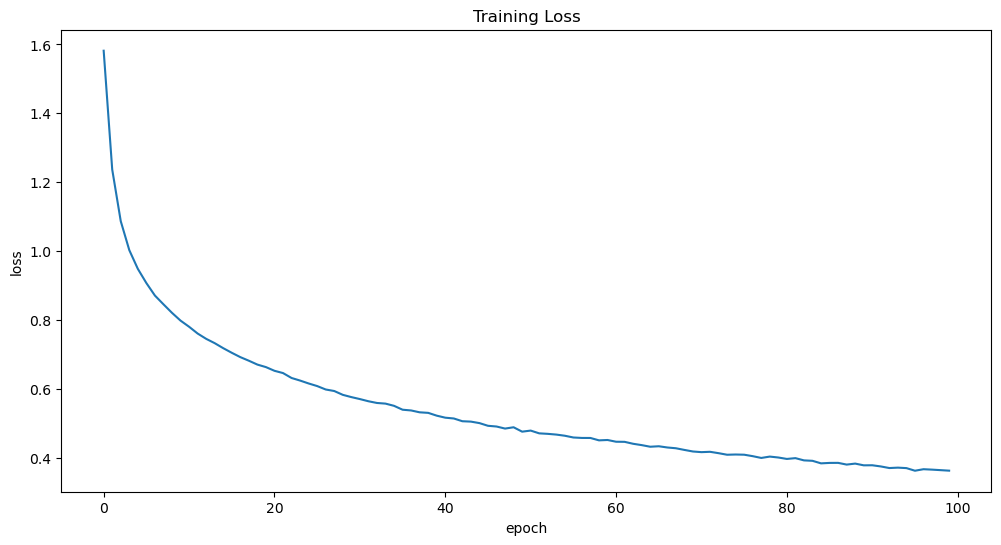

In [17]:
#(1) Plot traing loss
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

In [18]:
#(2) Check metrics
compute_metrics(model=model, loader=cifa_train_loader)

,metricName,value
0,accuracy,0.883680
1,precision,0.889793
2,recall,0.883680
3,f1,0.883460


#### 03.3. **일반화 성능 평가**

In [19]:
compute_metrics(model=model, loader=cifa_test_loader)

,metricName,value
0,accuracy,0.704400
1,precision,0.712702
2,recall,0.704400
3,f1,0.703584
